In [2]:
import os
os.environ["KMP_WARNINGS"] = "off"
import warnings
warnings.filterwarnings("ignore")

In [3]:
from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [4]:
common_config.figure_journal_basic()

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import torch
import sklearn
from captum.attr import IntegratedGradients

import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [6]:
G1_CYCLE = [
    "CDKN1A",
    {"CDKN1B", "CDKN1A"},
    "CDKN1B",
    {"CDKN1C", "CDKN1A"},
    {"CDKN1C", "CDKN1B"},
    "CDKN1C",
]

ERYTHROID = [
    {"CBL", "CNN1"},
    {"CBL", "PTPN12"},
    {"CBL", "PTPN9"},
    {"CBL", "UBASH3B"},
    {"SAMD1", "PTPN12"},
    {"SAMD1", "UBASH3B"},
    {"UBASH3B", "CNN1"},
    {"UBASH3B", "PTPN12"},
    {"UBASH3B", "PTPN9"},
    {"UBASH3B", "UBASH3A"},
    {"UBASH3B", "ZBTB25"},
    {"BPGM", "SAMD1"},
    "PTPN1",
    {"PTPN12", "PTPN9"},
    {"PTPN12", "UBASH3A"},
    {"PTPN12", "ZBTB25"},
    {"UBASH3A", "CNN1"},
]

PIONEER_FACTORS = [
    {"FOXA1", "FOXF1"},
    {"FOXA1", "FOXL2"},
    {"FOXA1", "HOXB9"},
    {"FOXA3", "FOXA1"},
    {"FOXA3", "FOXF1"},
    {"FOXA3", "FOXL2"},
    {"FOXA3", "HOXB9"},
    "FOXA3",
    {"FOXF1", "FOXL2"},
    {"FOXF1", "HOXB9"},
    {"FOXL2", "MEIS1"},
    "HOXA13",
    "HOXC13",
    {"POU3F2", "FOXL2"},
    "TP73",
    "MIDN",
    {"LYL1", "IER5L"},
    "HOXC13",
    {"DUSP9", "SNAI1"},
    {"ZBTB10", "SNAI1"},
]

GRANULOCYTE_APOPTOSIS = [
    "SPI1",
    "CEBPA",
    {"CEBPB", "CEBPA"},
    "CEBPB",
    {"CEBPE", "CEBPA"},
    {"CEBPE", "CEBPB"},
    {"CEBPE", "RUNX1T1"},
    {"CEBPE", "SPI1"},
    "CEBPE",
    {"ETS2", "CEBPE"},
    {"KLF1", "CEBPA"},
    {"FOSB", "CEBPB"},
    {"FOSB", "CEBPE"},
    {"ZC3HAV1", "CEBPA"},
    {"JUN", "CEBPA"},
]

PRO_GROWTH = [
    {"CEBPE", "KLF1"},
    "KLF1",
    {"KLF1", "BAK1"},
    {"KLF1", "MAP2K6"},
    {"KLF1", "TGFBR2"},
    "ELMSAN1",
    {"MAP2K3", "SLC38A2"},
    {"MAP2K3", "ELMSAN1"},
    "MAP2K3",
    {"MAP2K3", "MAP2K6"},
    {"MAP2K6", "ELMSAN1"},
    "MAP2K6",
    {"MAP2K6", "KLF1"},
]

MEGAKARYOCYTE = [
    {"MAPK1", "TGFBR2"},
    "MAPK1",
    {"ETS2", "MAPK1"},
    "ETS2",
    {"CEBPB", "MAPK1"},
]

programmes = {
    "G1 cell cycle": G1_CYCLE,
    "Erythroid": ERYTHROID,
    "Pioneer factors": PIONEER_FACTORS,
    "Granulocyte apoptosis": GRANULOCYTE_APOPTOSIS,
    "Pro-growth": PRO_GROWTH,
    "Megakaryocyte": MEGAKARYOCYTE,
}

In [7]:
adata = sc.read_h5ad("norman/data/norman_preprocessed.h5ad")
adata.obs["guide_ids"] = adata.obs["guide_ids"].cat.rename_categories({"": "control"})
adata

AnnData object with n_obs × n_vars = 111255 × 4000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

In [8]:
gene_programme = []

for target_pert in adata.obs["perturbation_name"]:
    if target_pert == "control":
        gene_programme.append("Control")
        continue

    found_programme = False
    for programme, pert_list in programmes.items():
        for pert in pert_list:
            if (type(pert) == set and pert == set(target_pert.split("+"))) or (
                target_pert == pert
            ):
                gene_programme.append(programme)
                found_programme = True
                break

    if not found_programme:
        gene_programme.append("Unknown")

adata.obs["gene_programme"] = gene_programme
adata.obs["gene_programme"] = adata.obs["gene_programme"].astype("category")

In [9]:
ps = pt.tl.MLPClassifierSpace()
pert_embeddings = ps.compute(
    adata,
    target_col="perturbation_name",
    hidden_dim=[512, 256],
    dropout=0.05,
    batch_size=128,
    batch_norm=True,
    max_epochs=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params | Mode 
--------------------------------------
0 | net  | MLP  | 2.2 M  | train
--------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.969     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     4.088469505310059     │
└───────────────────────────┴───────────────────────────┘

In [10]:
ps.net

MLP(
  (network): Sequential(
    (0): Linear(in_features=4000, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=256, out_features=237, bias=True)
  )
)

In [22]:
def compute_feature_importances(gene_programme: str):
    target_col = "perturbation_name"

    ps.net.eval()

    # Get data for pro-growth programme and prepare for attribution
    input_adata = adata[adata.obs["gene_programme"] == gene_programme]
    X = torch.tensor(input_adata.X.toarray(), dtype=torch.float32)
    baseline = torch.zeros_like(X)

    encoder = sklearn.preprocessing.OneHotEncoder()
    encoder.fit(adata.obs[target_col].values.reshape(-1, 1))
    targets = encoder.transform(input_adata.obs[target_col].values.reshape(-1, 1)).toarray()
    targets = torch.argmax(torch.tensor(targets, dtype=torch.long), dim=1).tolist()

    ig = IntegratedGradients(ps.net)
    attributions = ig.attribute(X, baseline, target=targets)

    # Average the attributions across all samples
    feature_importances = attributions.mean(dim=0).detach().cpu().numpy()

    feature_names = adata.var_names
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })

    importance_df = importance_df.sort_values('importance', key=abs, ascending=False)

    # Get all unique target genes from perturbation names
    pert_genes = set()
    for pert in input_adata.obs[target_col].unique():
        pert_genes.update(pert.split('+'))

    # Plot top 20 most important features
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title(f'{gene_programme} - Feature Importance using Integrated Gradients')
    plt.xlabel('Average Attribution')
    plt.ylabel('Feature')
    
    # Color genes that appear in target genes
    for tick in ax.get_yticklabels():
        if tick.get_text() in pert_genes:
            tick.set_color('red')
            tick.set_weight('bold')
            
    plt.tight_layout()
    plt.show()

    print("\nTop 10 most important features:")
    print(importance_df.head(10))

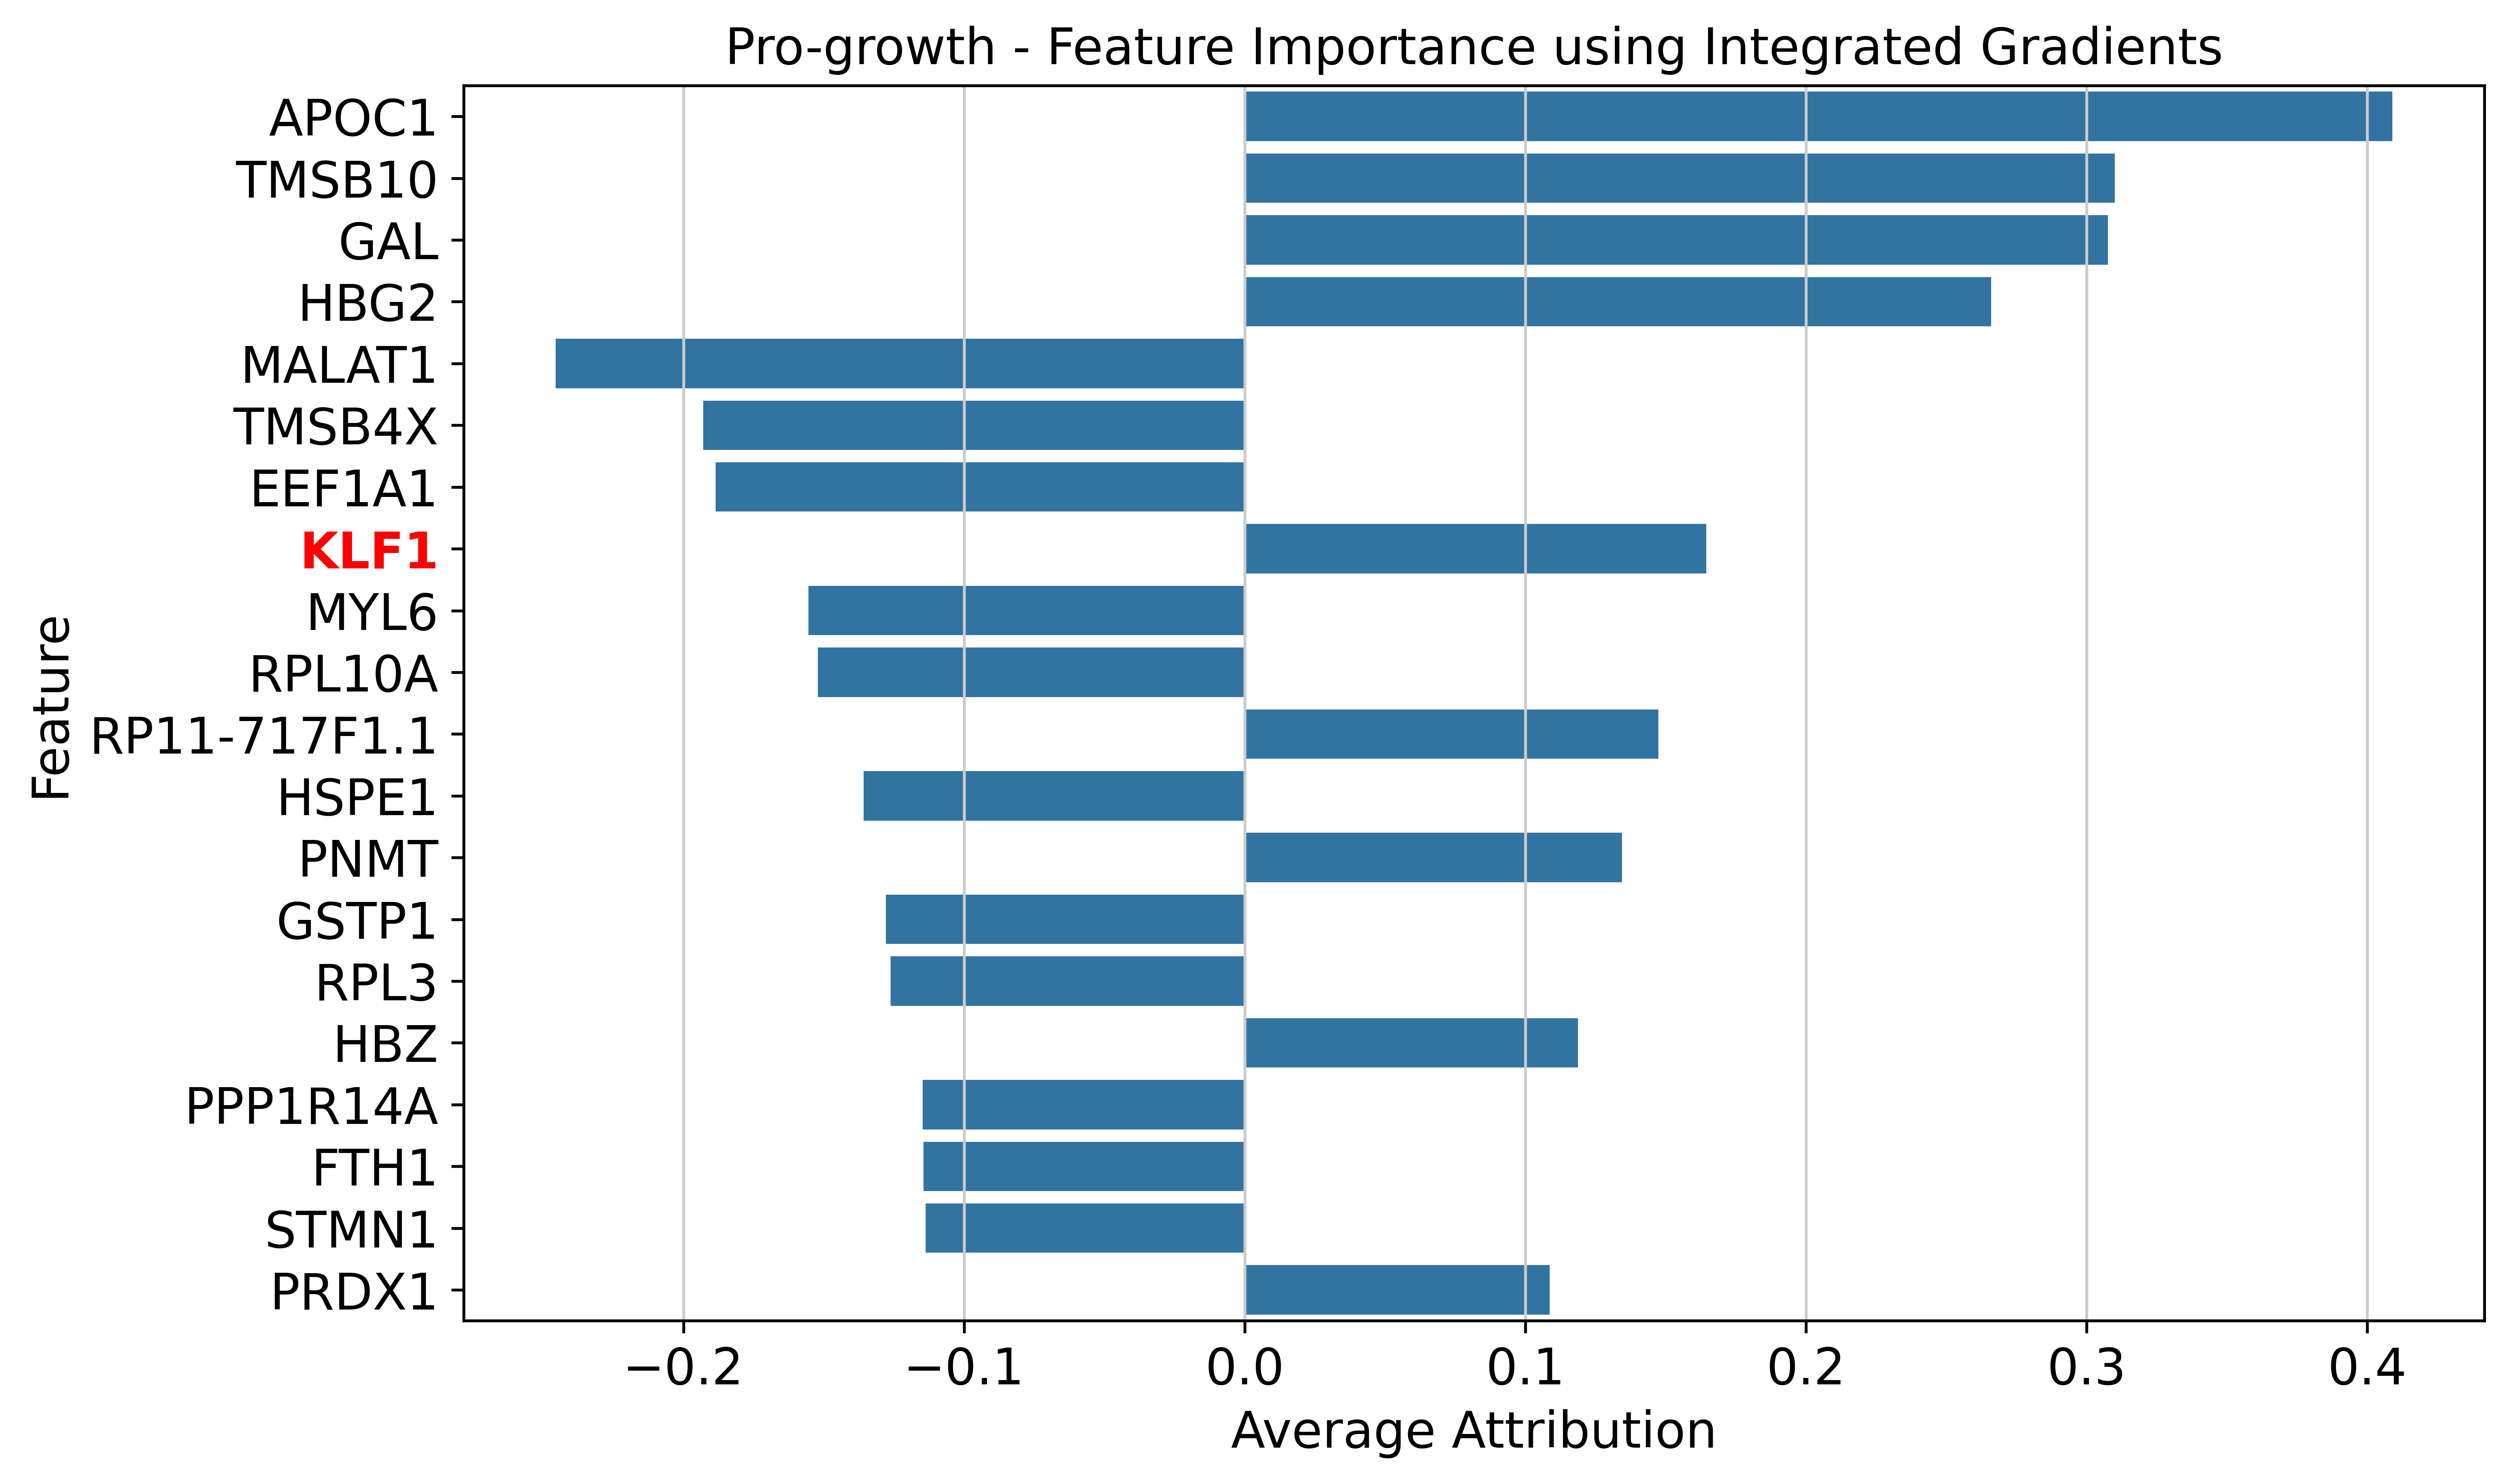


Top 10 most important features:
     feature  importance
3766   APOC1    0.409053
548   TMSB10    0.310094
2219     GAL    0.307668
2101    HBG2    0.266017
2195  MALAT1   -0.245574
1686  TMSB4X   -0.192861
1411  EEF1A1   -0.188513
3656    KLF1    0.164448
2559    MYL6   -0.155427
1362  RPL10A   -0.152141


In [23]:
compute_feature_importances("Pro-growth")

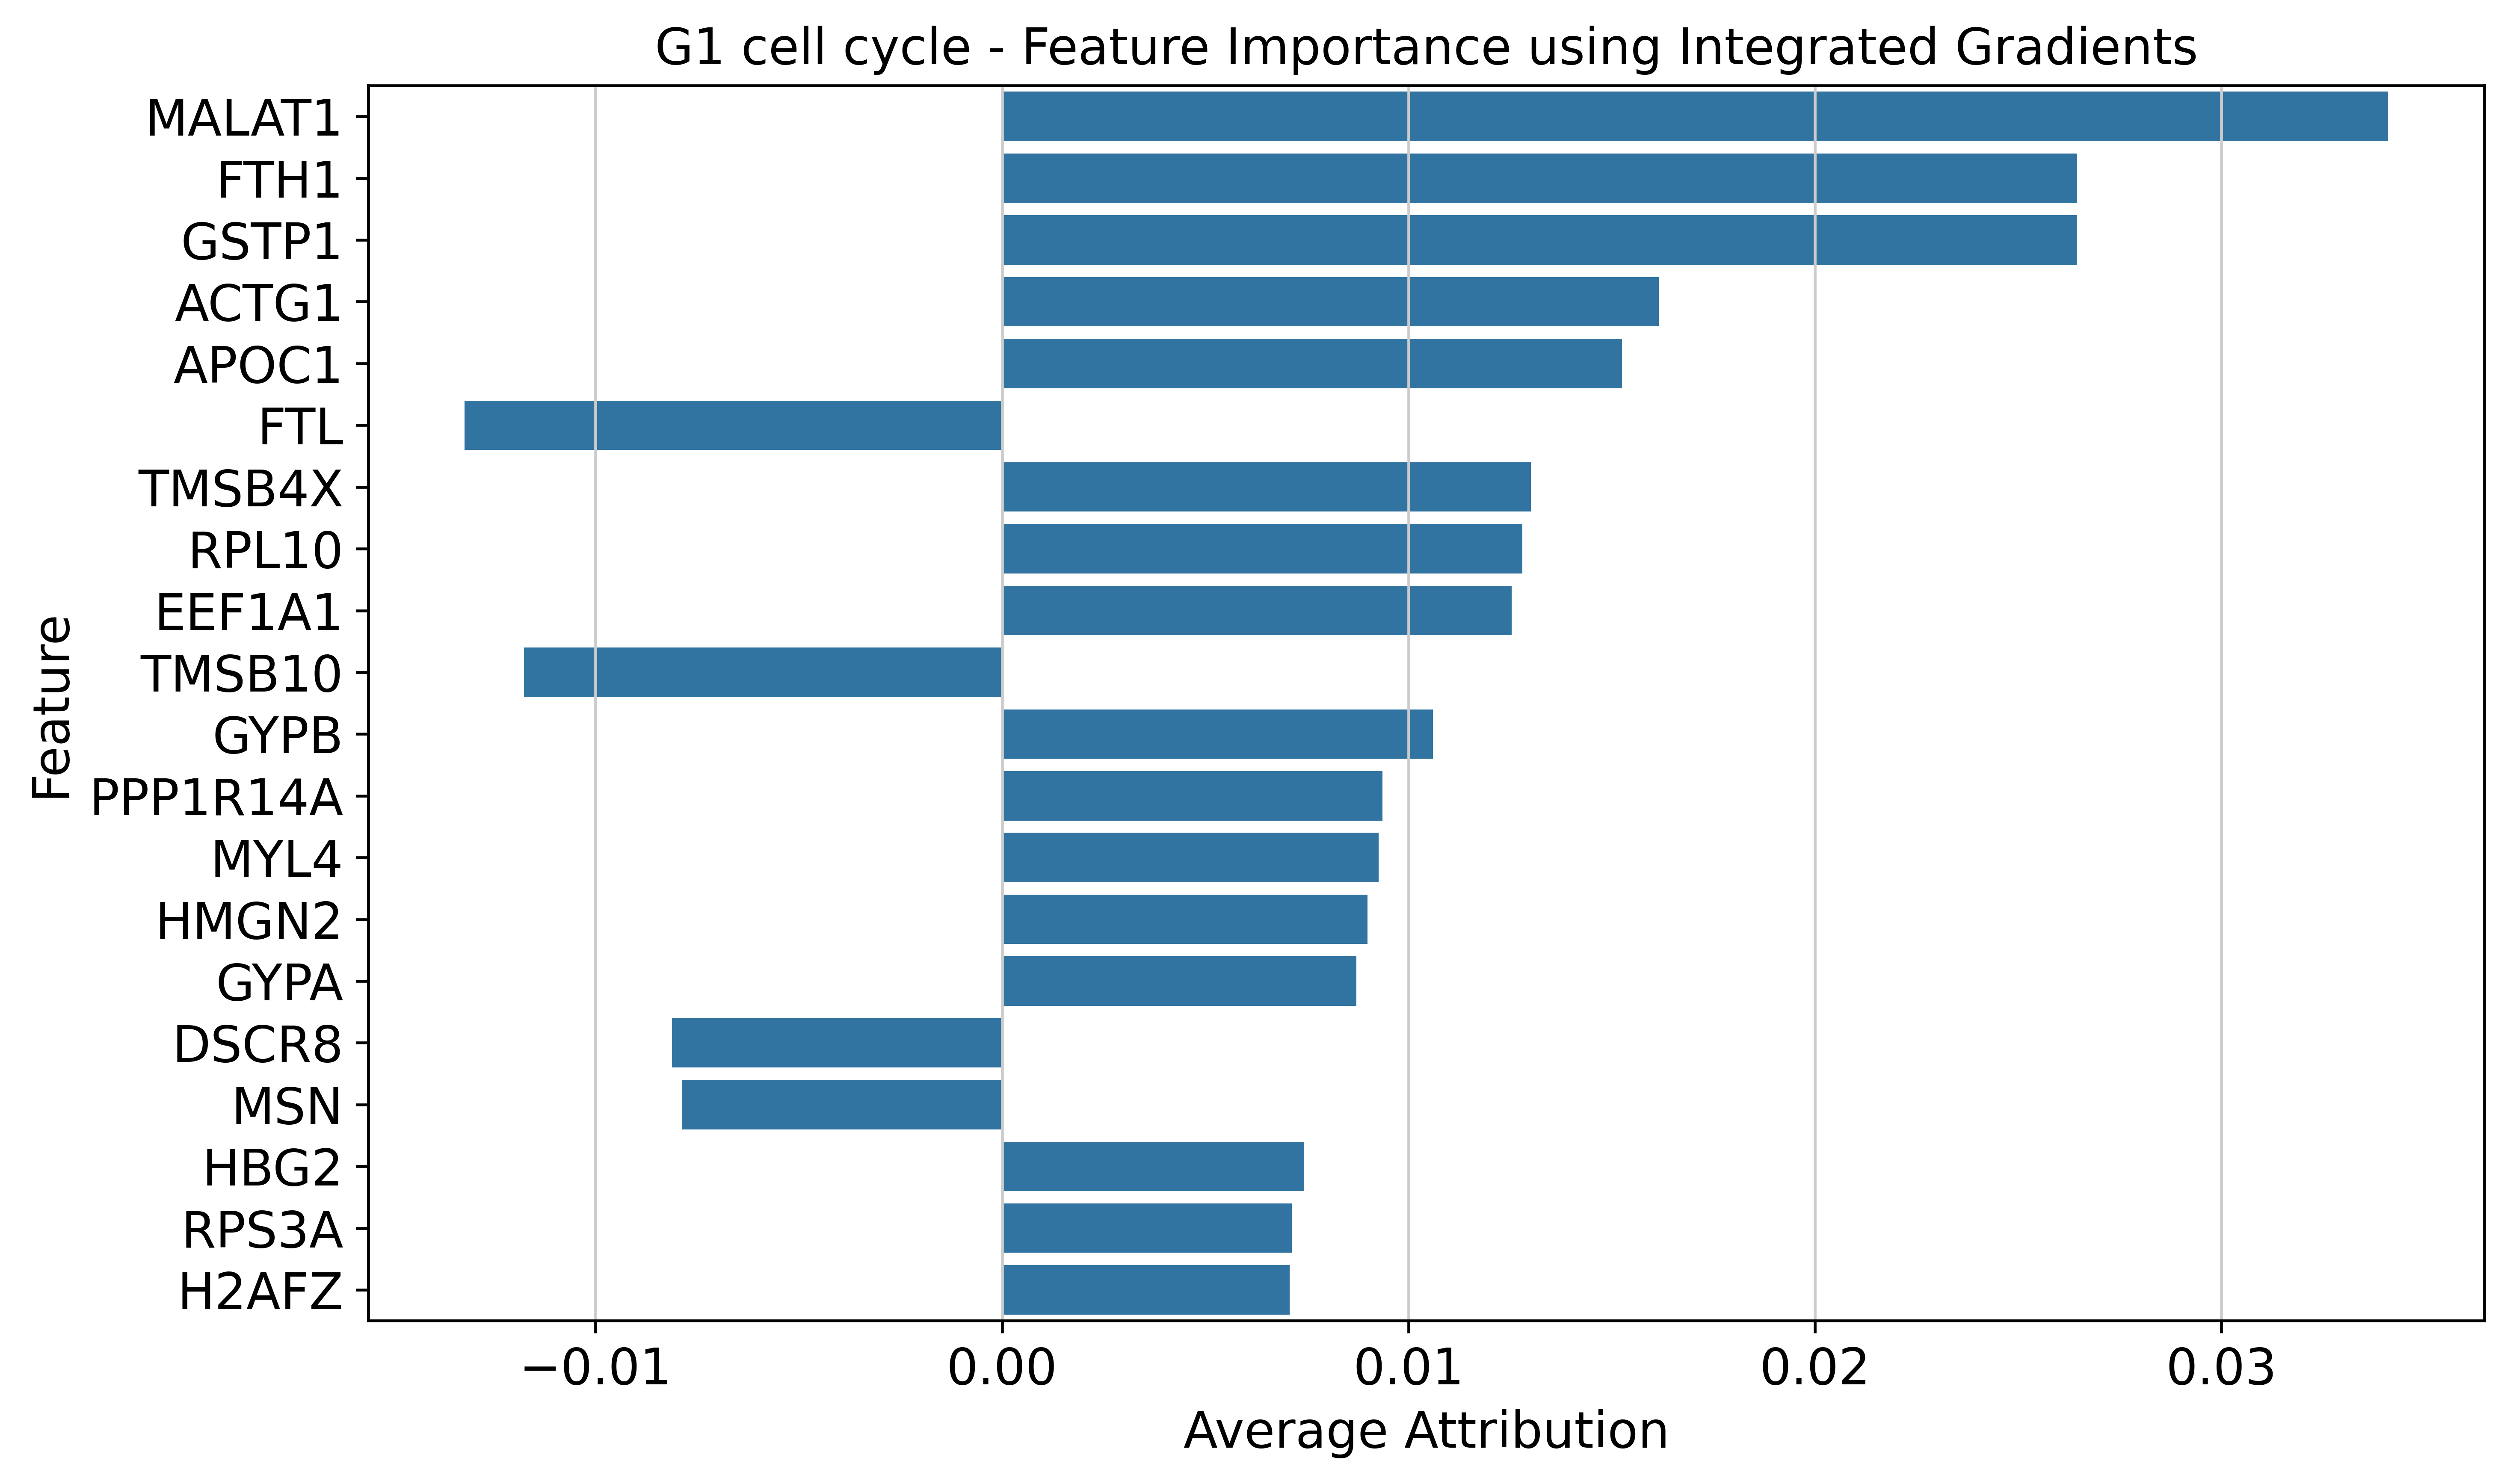


Top 10 most important features:
     feature  importance
2195  MALAT1    0.034104
2167    FTH1    0.026451
2214   GSTP1    0.026440
3390   ACTG1    0.016161
3766   APOC1    0.015253
3797     FTL   -0.013223
1686  TMSB4X    0.013007
1786   RPL10    0.012798
1411  EEF1A1    0.012539
548   TMSB10   -0.011759


In [24]:
compute_feature_importances("G1 cell cycle")

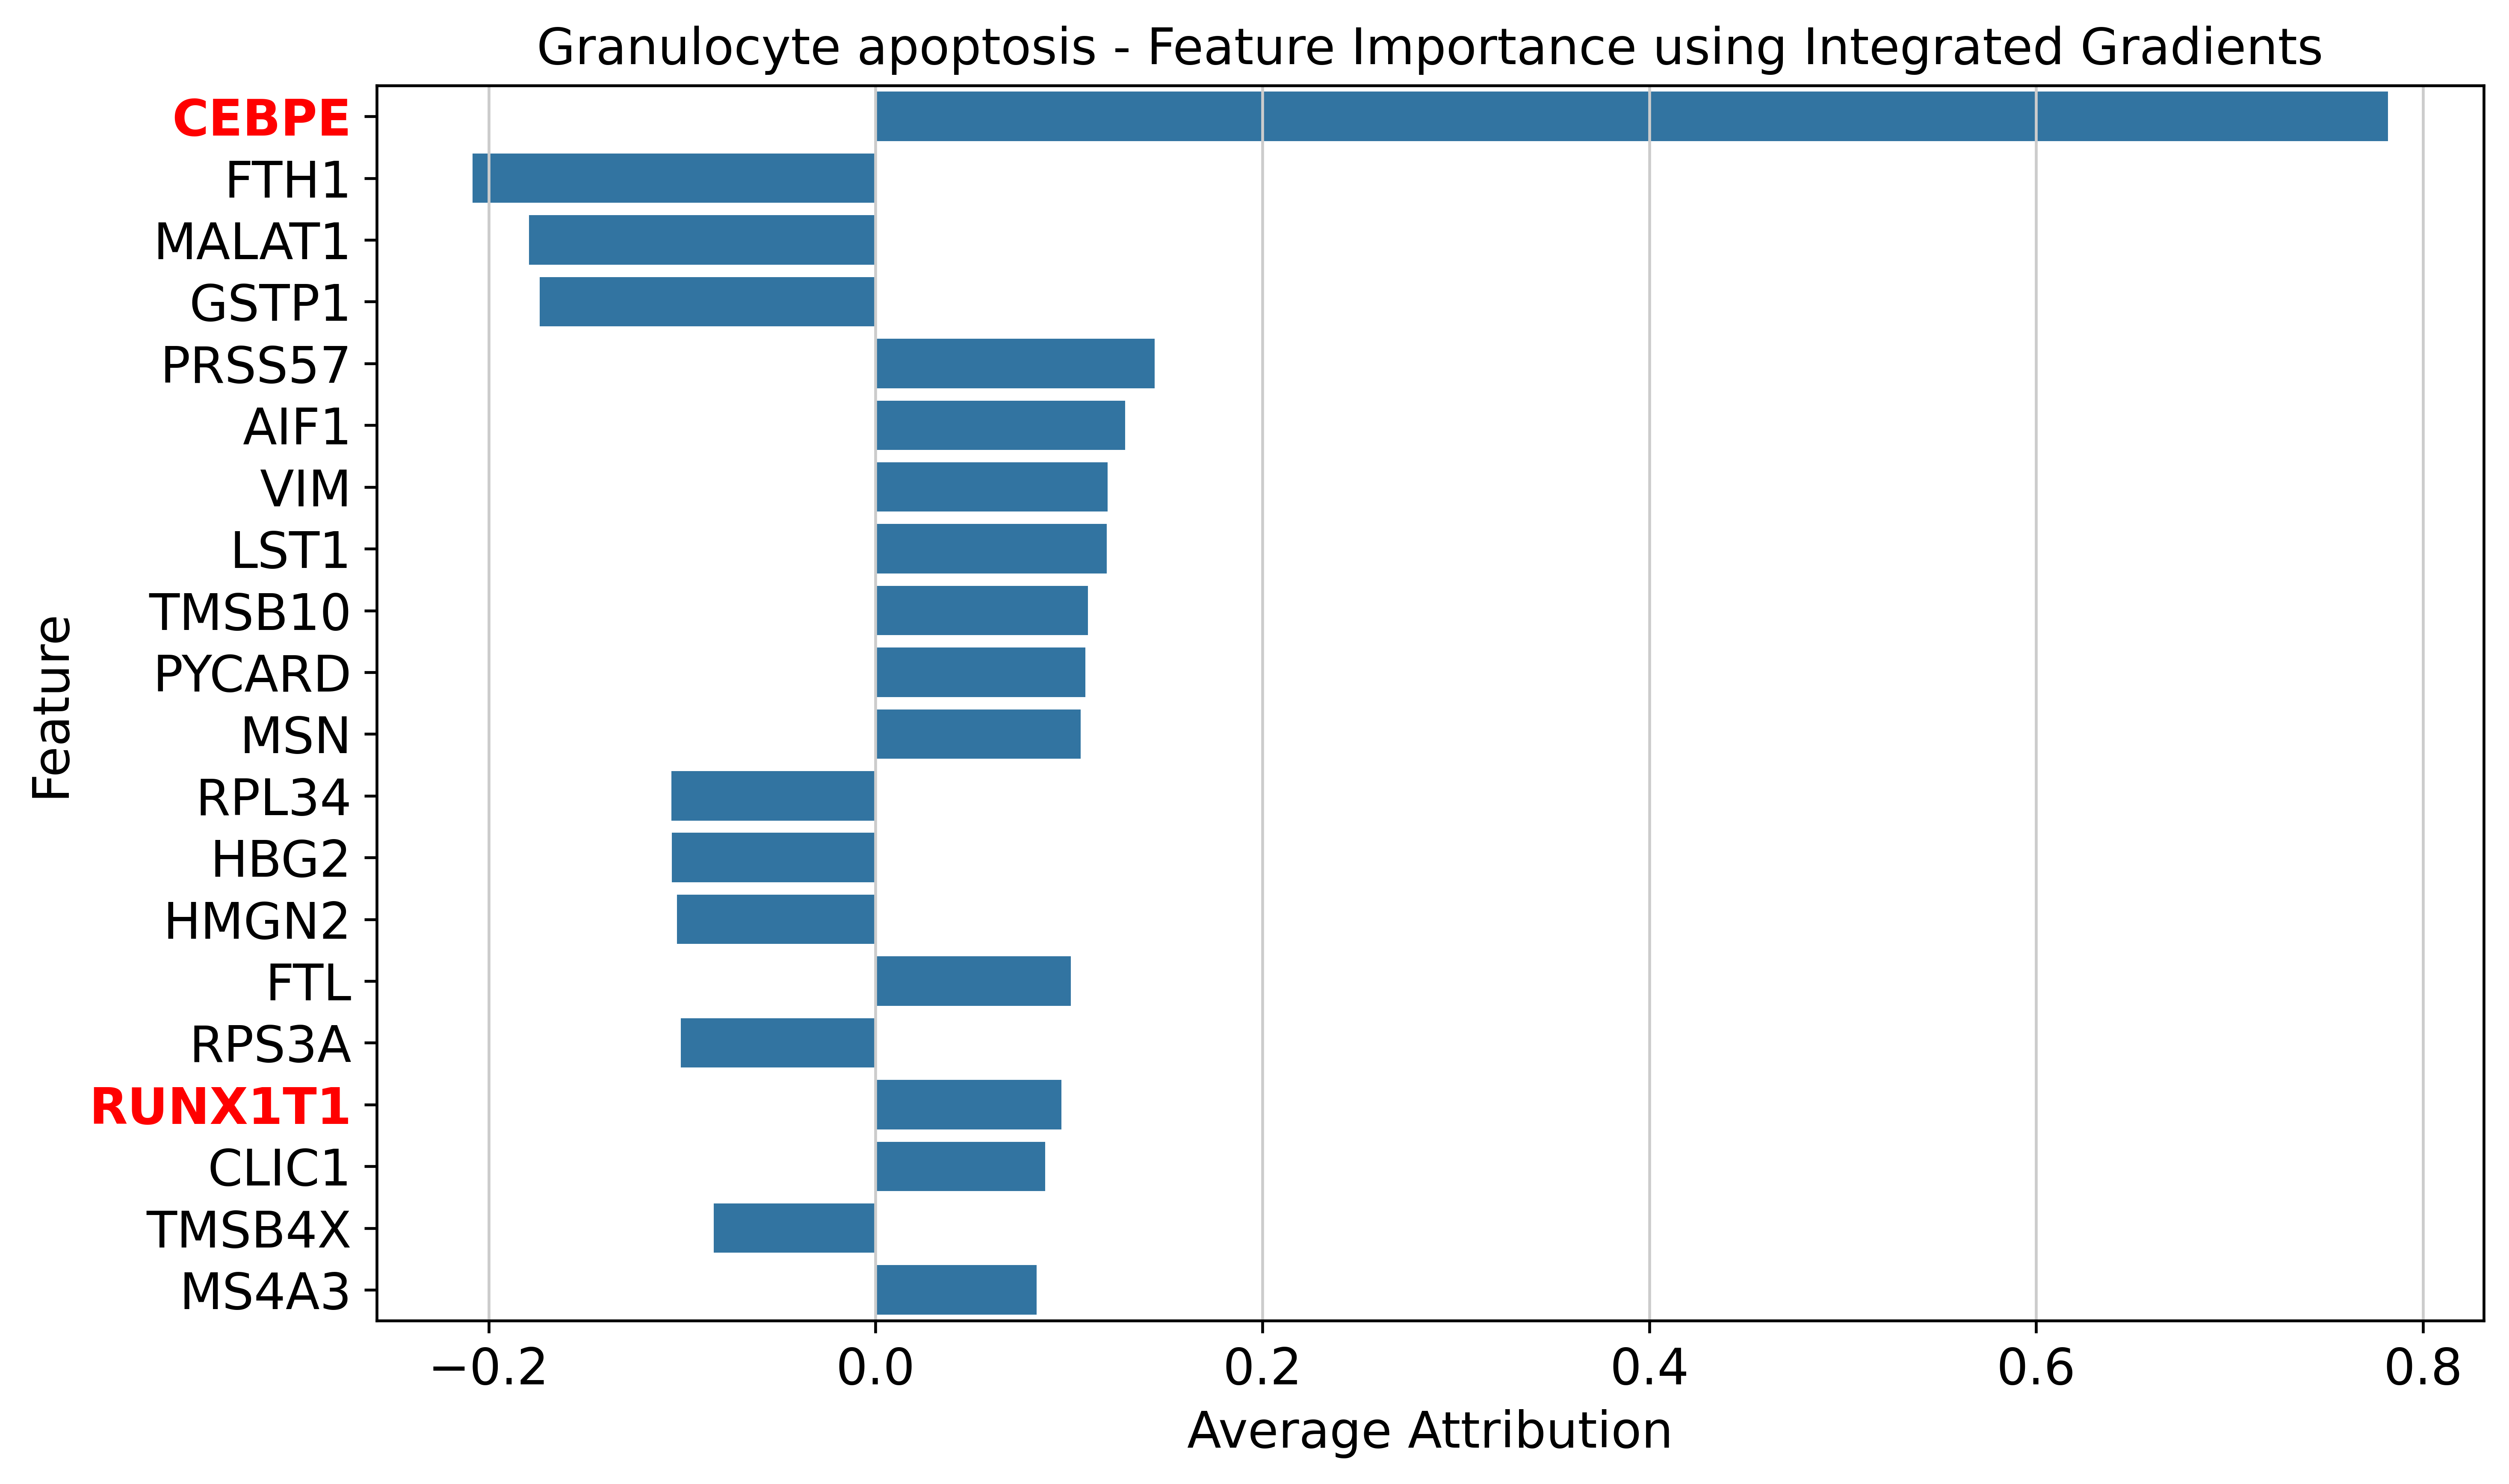


Top 10 most important features:
     feature  importance
2747   CEBPE    0.781834
2167    FTH1   -0.208414
2195  MALAT1   -0.179027
2214   GSTP1   -0.173636
3573  PRSS57    0.144375
1336    AIF1    0.128982
2317     VIM    0.120027
1335    LST1    0.119484
548   TMSB10    0.109701
3054  PYCARD    0.108482


In [25]:
compute_feature_importances("Granulocyte apoptosis")

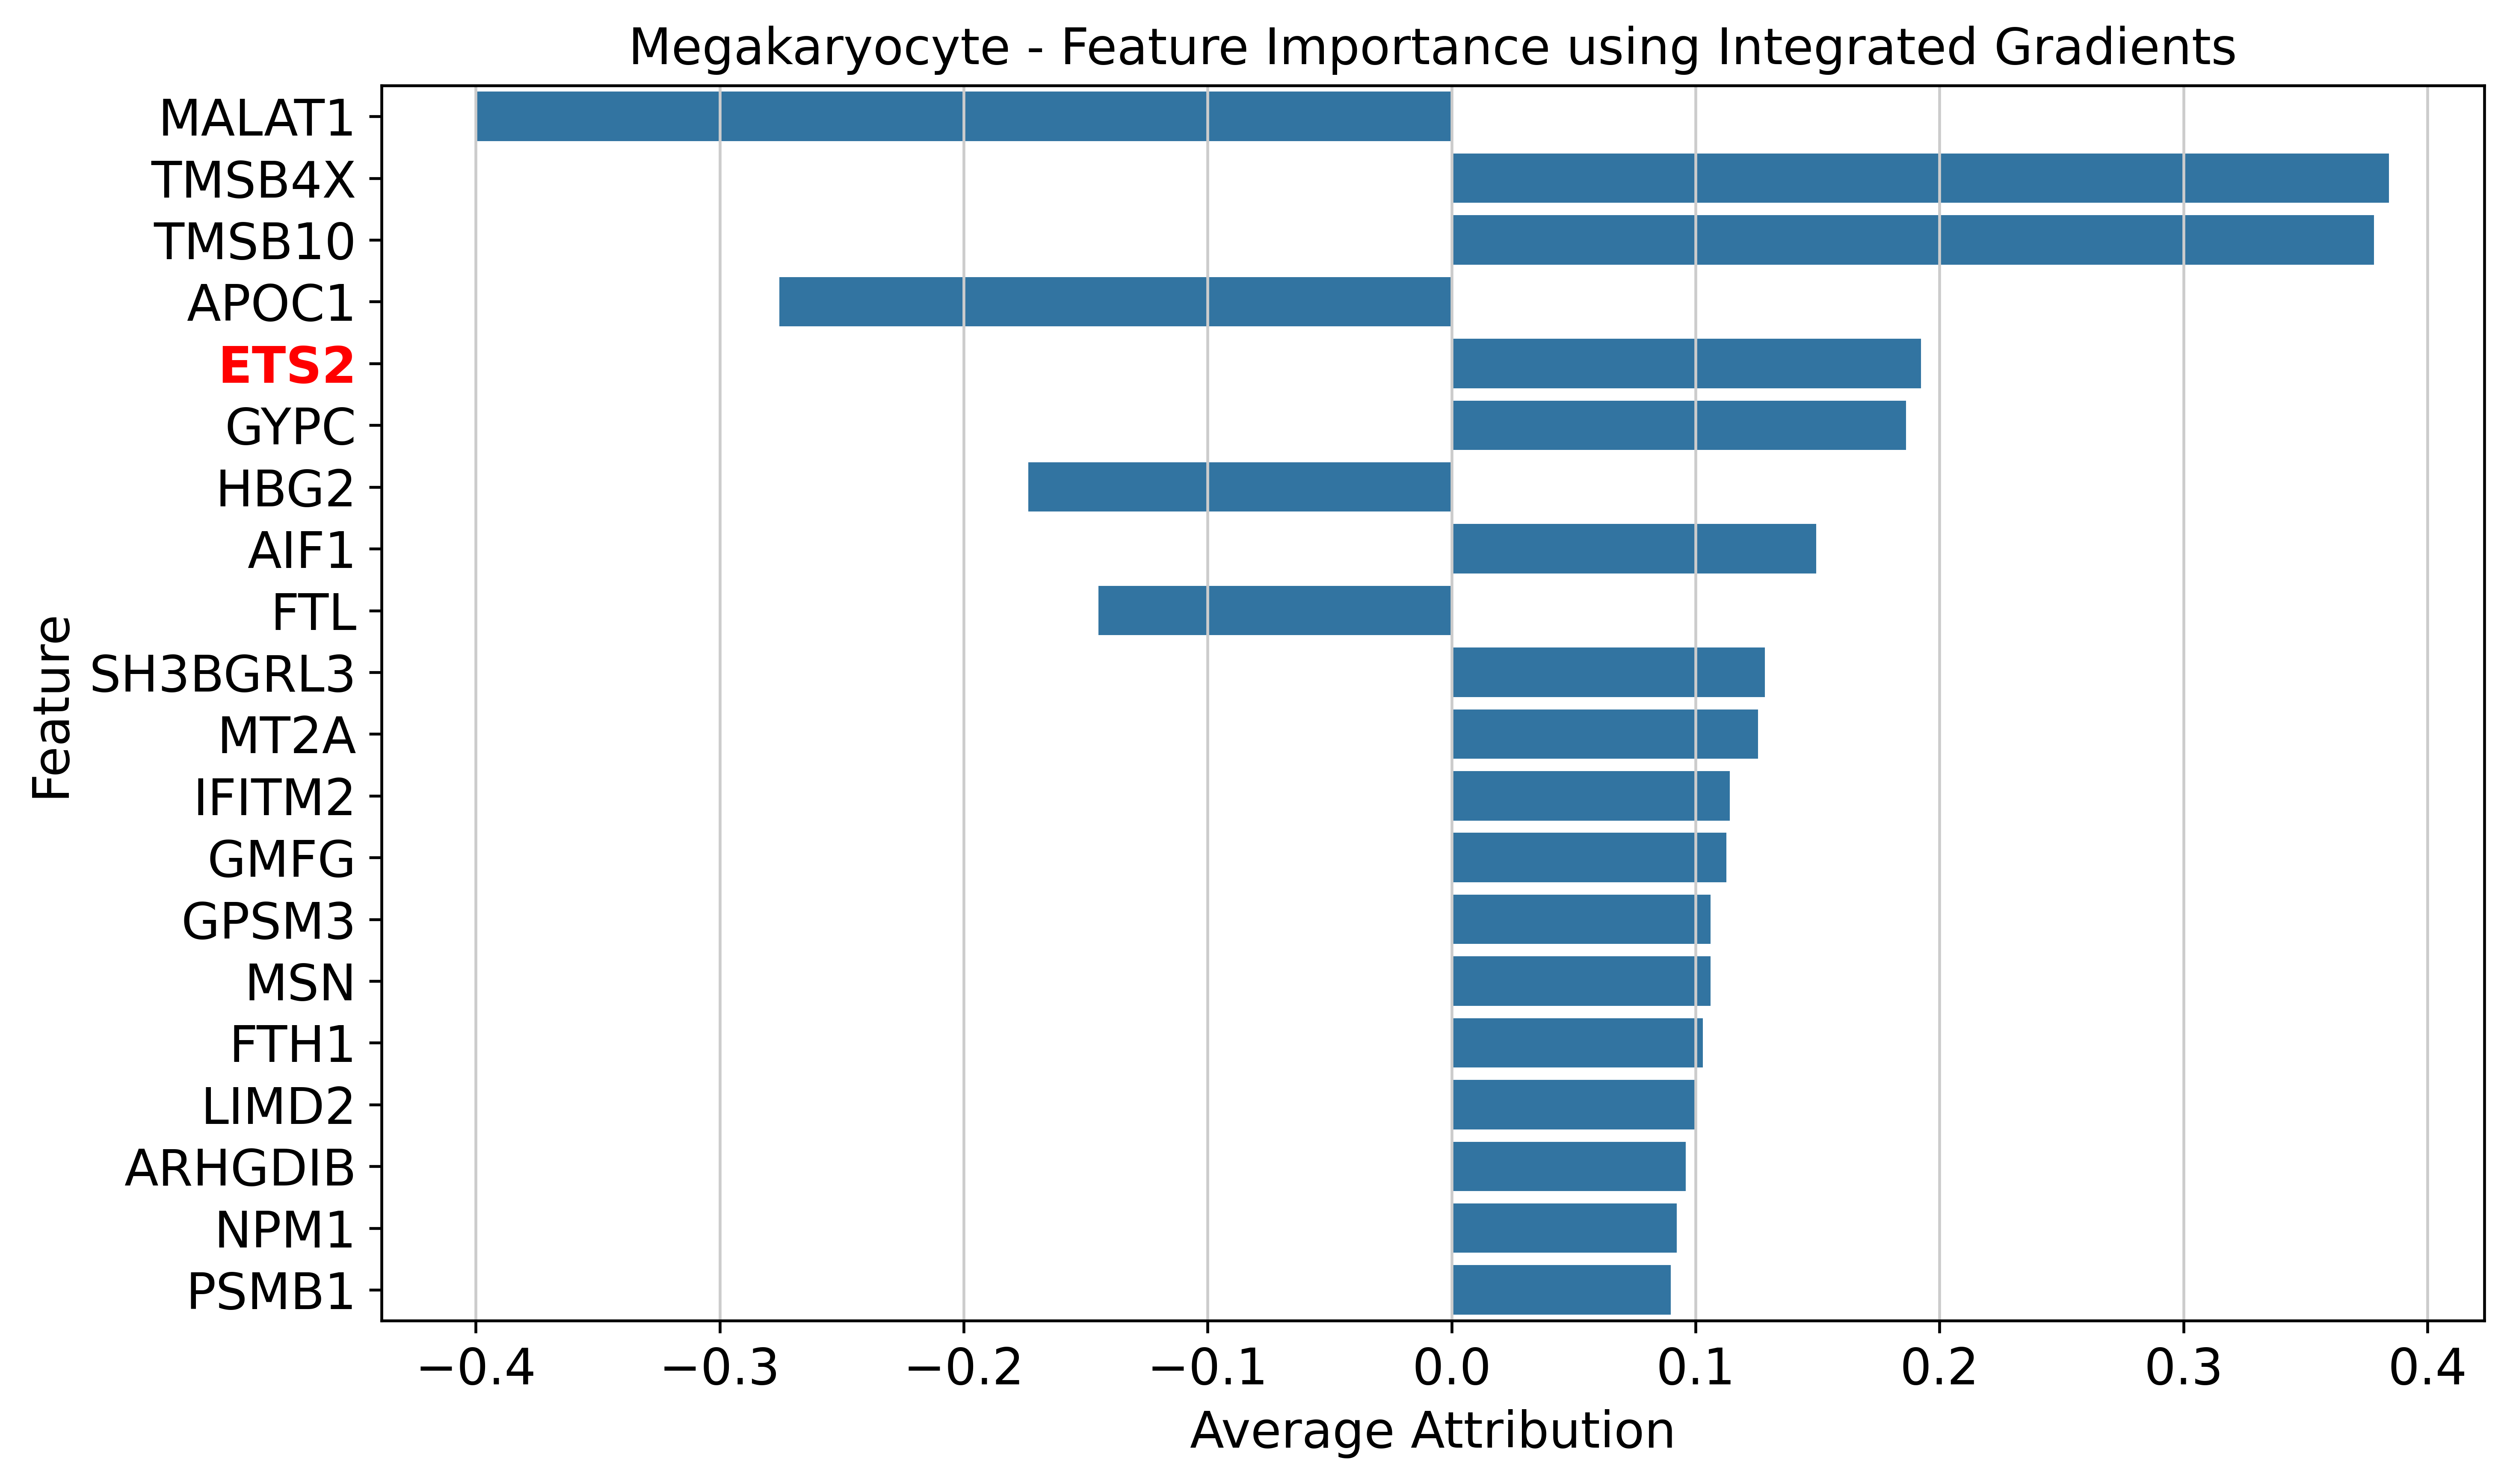


Top 10 most important features:
       feature  importance
2195    MALAT1   -0.399530
1686    TMSB4X    0.384156
548     TMSB10    0.378019
3766     APOC1   -0.275621
3970      ETS2    0.192413
597       GYPC    0.186231
2101      HBG2   -0.173545
1336      AIF1    0.149411
3797       FTL   -0.144832
74    SH3BGRL3    0.128306


In [26]:
compute_feature_importances("Megakaryocyte")

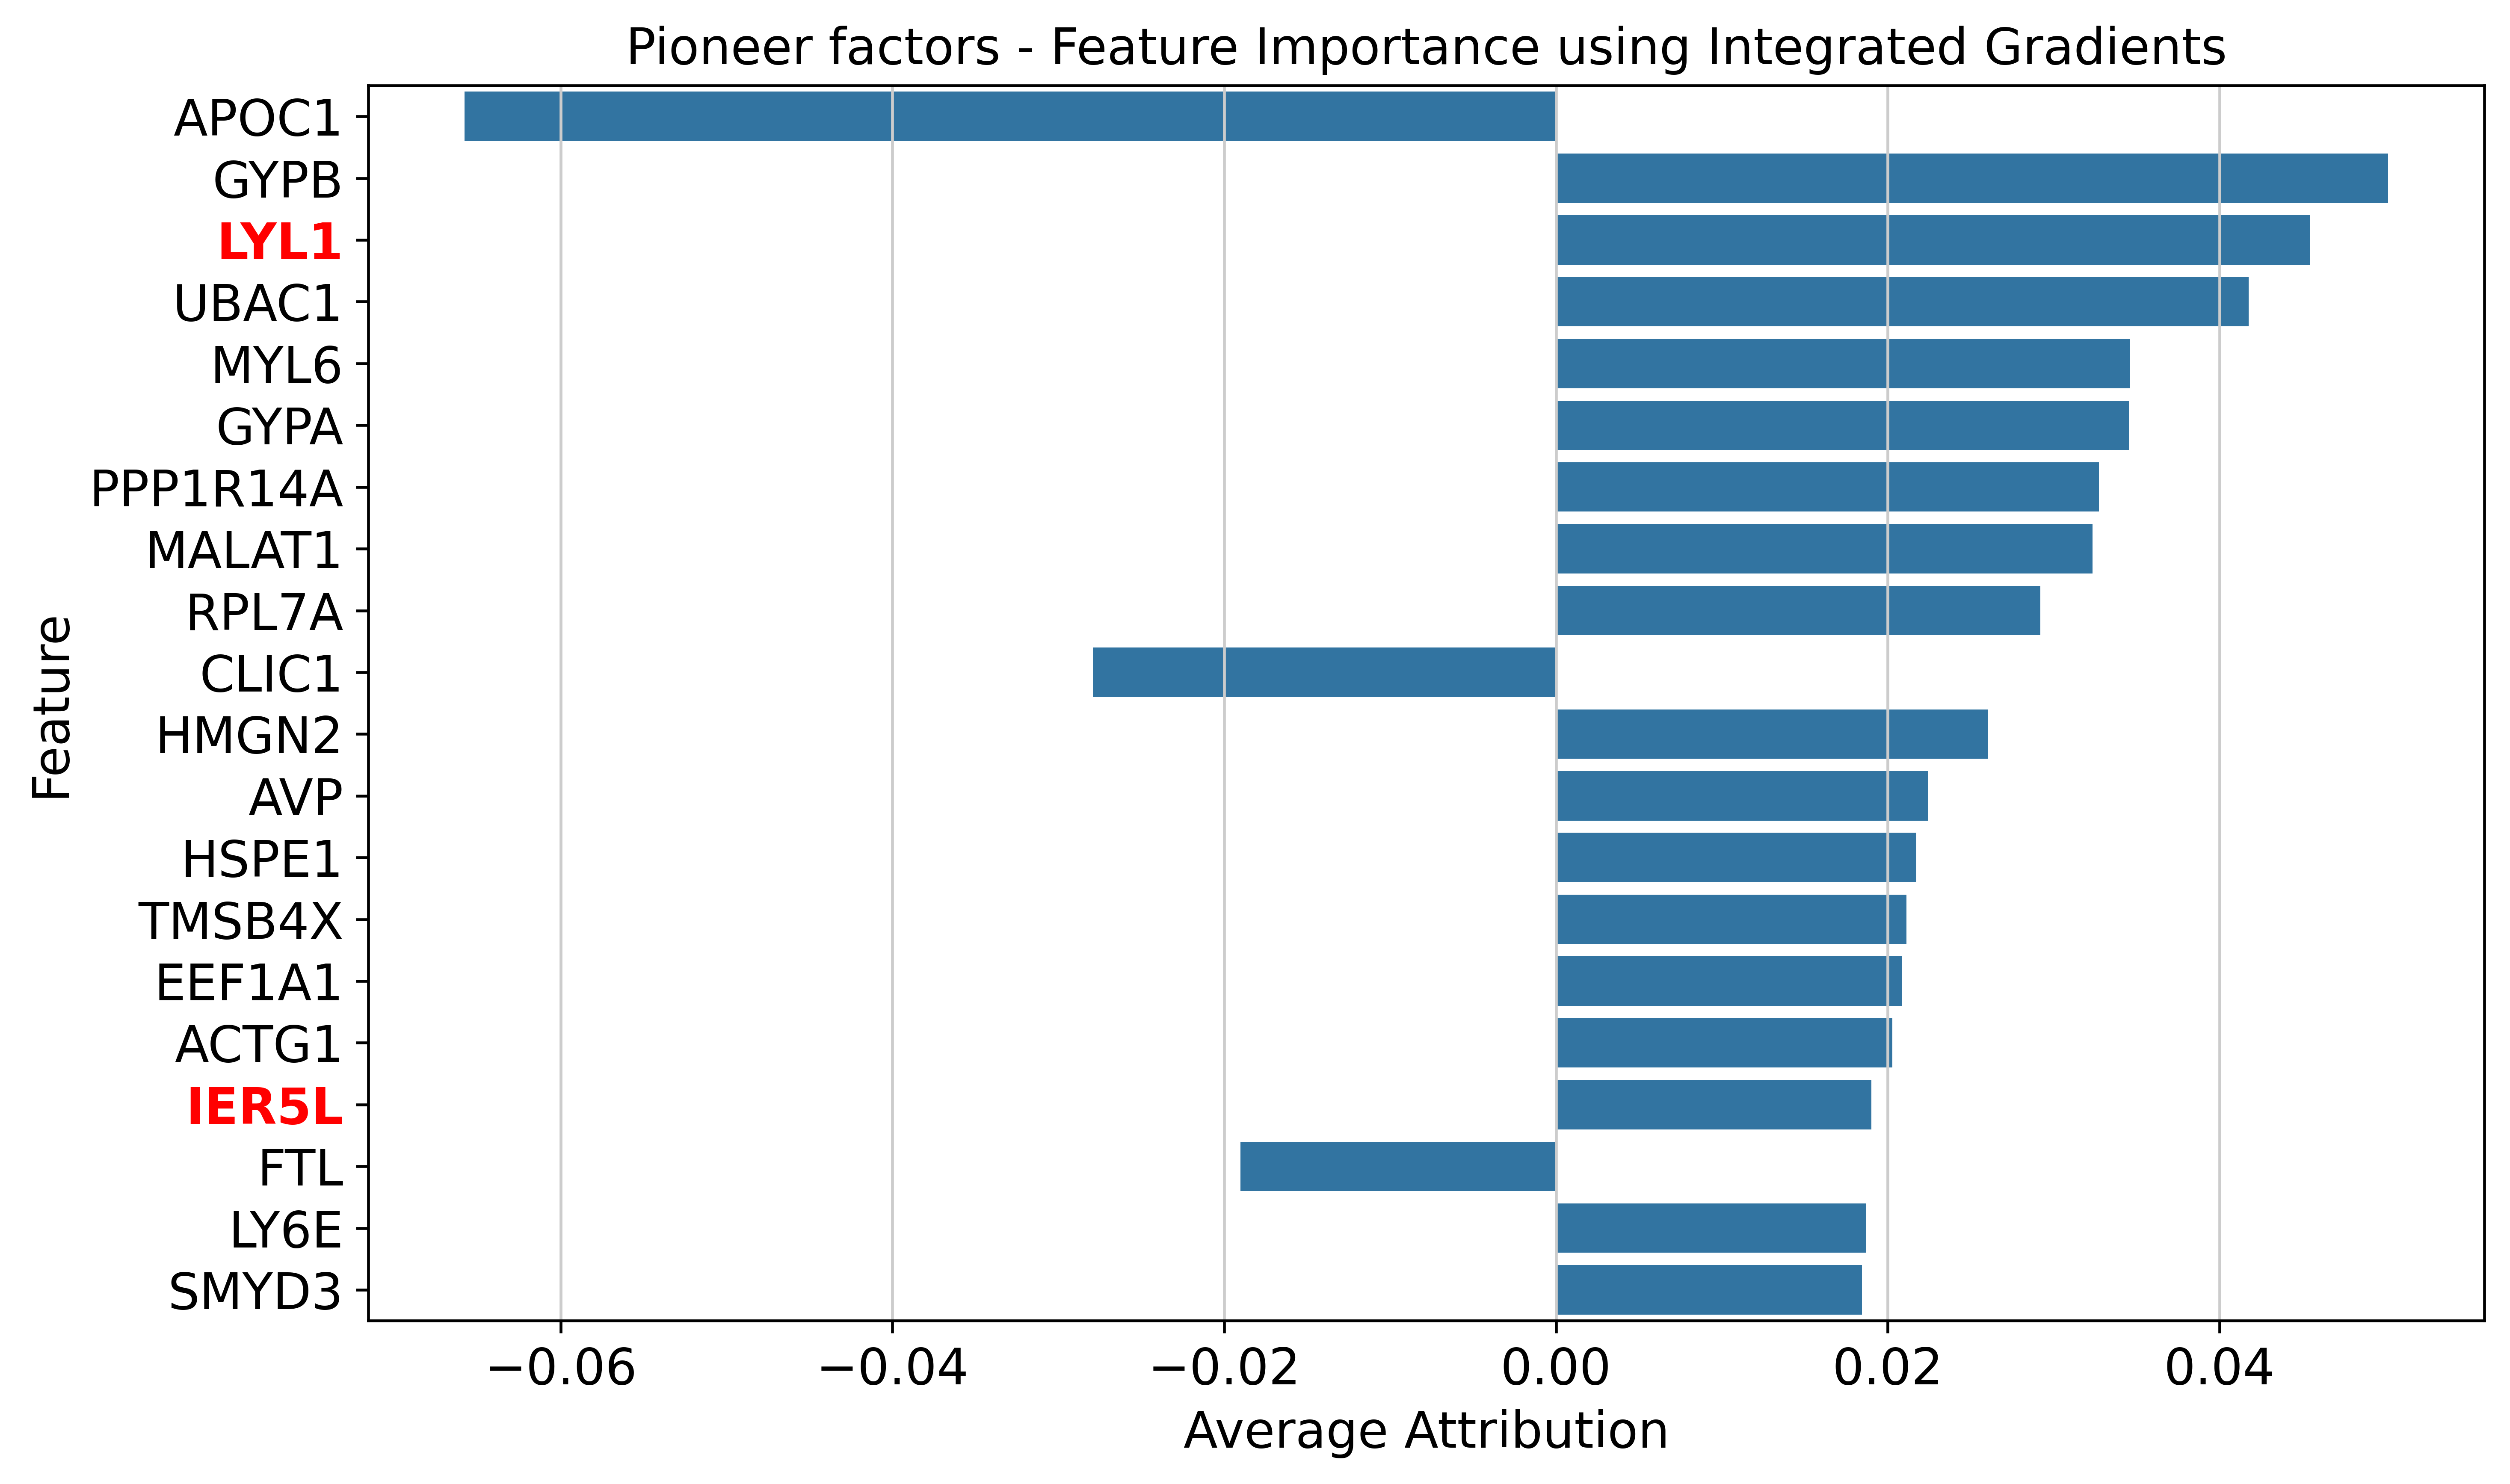


Top 10 most important features:
       feature  importance
3766     APOC1   -0.065797
1066      GYPB    0.050180
3658      LYL1    0.045455
2062     UBAC1    0.041766
2559      MYL6    0.034593
1067      GYPA    0.034545
3726  PPP1R14A    0.032749
2195    MALAT1    0.032352
2055     RPL7A    0.029194
1340     CLIC1   -0.027922


In [27]:
compute_feature_importances("Pioneer factors")

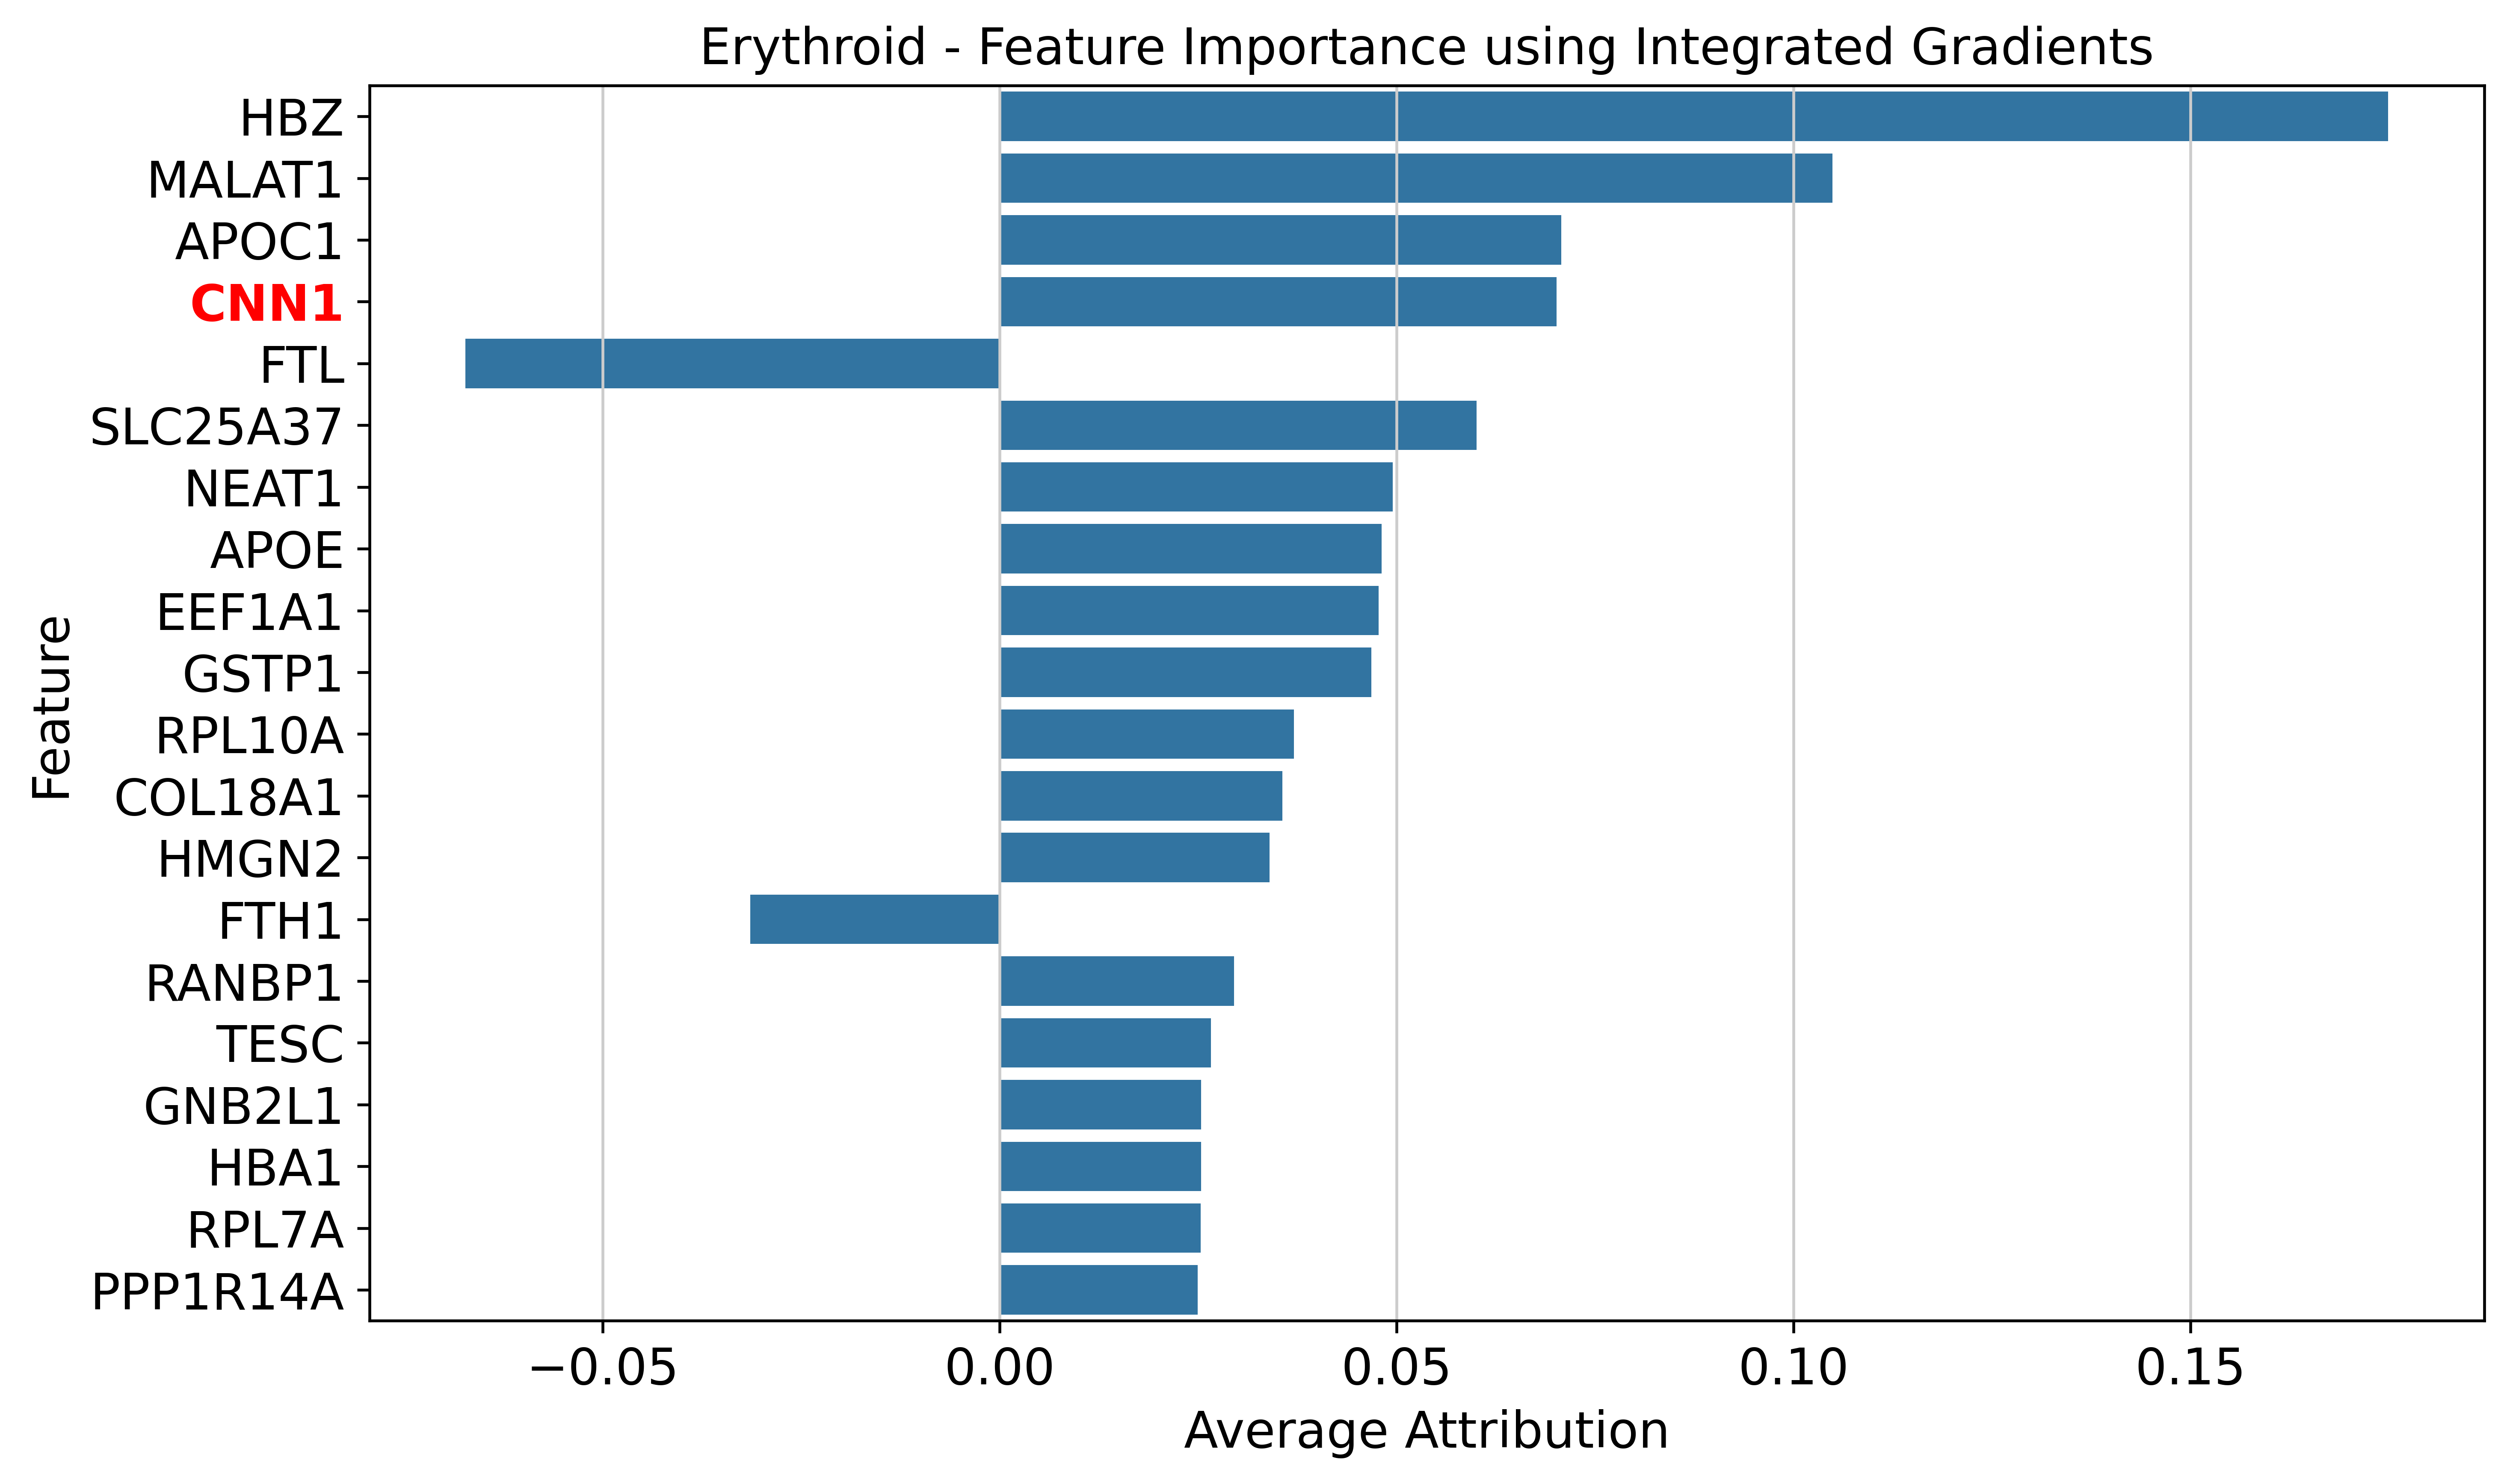


Top 10 most important features:
       feature  importance
2958       HBZ    0.174894
2195    MALAT1    0.104912
3766     APOC1    0.070719
3647      CNN1    0.070144
3797       FTL   -0.067301
1813  SLC25A37    0.060083
2193     NEAT1    0.049508
3765      APOE    0.048085
1411    EEF1A1    0.047694
2214     GSTP1    0.046824


In [28]:
compute_feature_importances("Erythroid")

In [30]:
torch.save(ps.net.state_dict(), 'norman/output/norman_mlp_classifier.pt')